<a href="https://colab.research.google.com/github/bipinKrishnan/fastai_course/blob/master/cyclicLR_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from random import random
from tqdm.notebook import tqdm

## Cyclical lr from scratch

In [4]:
def cyclical_lr_np(iter, step_size, base_lr, max_lr):
  cycle = np.floor(1 + (iter / (2*step_size)))
  x = np.abs((iter/step_size) - 2*cycle + 1)

  lr = base_lr + (max_lr-base_lr) * (np.max((0, (1-x))))

  return lr

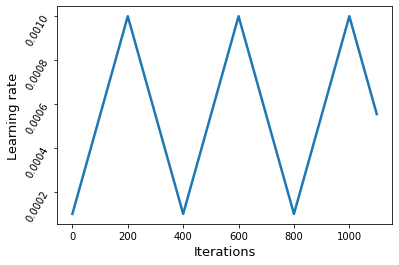

In [5]:
lr = []
for i in range(1100):
  lr.append(cyclical_lr_np(i, 200, 0.0001, 0.001))

plt.plot(lr, linewidth=2.5)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Learning rate", fontsize=13)
plt.yticks(rotation=60)
plt.savefig("foo1.jpg")

## Train a PyTorch model using above function

In [6]:
from torch import nn, optim
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

In [ ]:
transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.ToTensor()                                
])

dataset = datasets.MNIST('./data', train=False, download=True)

In [ ]:
class LoadData(Dataset):
  def __init__(self, data, target, transform):
    super().__init__()
    self.data = data
    self.target = target
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return (self.transform(self.data[idx]), self.target[idx])


In [9]:
bs = 32
trainloader = DataLoader(LoadData(dataset.data[:8000], dataset.targets[:8000], transform), bs, shuffle=True)
valloader = DataLoader(LoadData(dataset.data[8000:], dataset.targets[8000:], transform), bs)

In [10]:
for data, label in trainloader:
  print(data.shape, label.shape)
  break

for data, label in valloader:
  print(data.shape, label.shape)
  break

torch.Size([32, 1, 28, 28]) torch.Size([32])
torch.Size([32, 1, 28, 28]) torch.Size([32])


In [11]:
def validate(dataloader):
  correct = 0.0
  for inp, output in dataloader:
    out = model(inp.to(device))

    loss = criterion(out, output.to(device))

    out = torch.argmax(out.data, 1)

    correct += (out==output.to(device)).sum()

  return loss.item(), (correct.item()/(bs*len(valloader)))

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = models.resnet18(pretrained=False)

# uncoment the below code to download pretrained model & freeze the layers
# model = models.resnet18(pretrained=True)
# for params in model.parameters():
#   params.requires_grad = False

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, 10)

criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

In [30]:
model = model.to(device)

## LR range test

In [ ]:
!pip install torch-lr-finder

In [28]:
from torch_lr_finder import LRFinder

In [ ]:
lr_finder = LRFinder(model, opt, criterion, device=device)
lr_finder.range_test(trainloader, valloader, start_lr=1e-07, end_lr=10)

LR suggestion: steepest gradient
Suggested LR: 5.21E-04


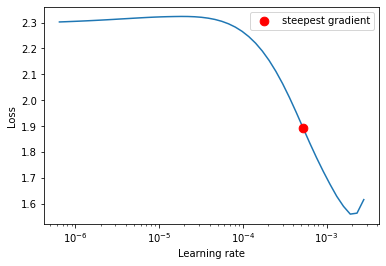

In [34]:
lr_finder.plot()
lr_finder.reset()

Training using cyclical lr

In [61]:
epochs = 8
acc = []
lr = []
iter_counter = 0

for i in tqdm(range(epochs), total=epochs, leave=False):
  model.train()
  for data, labels in tqdm(trainloader, total=len(trainloader), leave=False):

    #updating the learning rate
    opt.param_groups[0]['lr'] = cyclical_lr_np(iter_counter, 2*len(trainloader), 1e-6, 3e-2)

    opt.zero_grad()

    out = model(data.to(device))
    loss = criterion(out, labels.to(device))
    loss.backward()

    opt.step()

    lr.append(opt.param_groups[0]['lr'])
    iter_counter += 1

  model.eval()
  valid = validate(valloader)
  acc.append(valid[1])

  print(f"Epoch: {i+1}/{epochs}\ttrain_loss: {loss.item()}\tval_loss: {valid[0]}\tacc: {valid[1]}\n") 

Epoch: 1/8	train_loss: 1.9550628662109375	val_loss: 1.7536709308624268	acc: 0.6463293650793651



Epoch: 2/8	train_loss: 0.018391886726021767	val_loss: 0.9135429859161377	acc: 0.8452380952380952



Epoch: 3/8	train_loss: 0.7393415570259094	val_loss: 0.0035819108597934246	acc: 0.9702380952380952



Epoch: 4/8	train_loss: 0.0012923687463626266	val_loss: 0.0001602256525075063	acc: 0.9811507936507936



Epoch: 5/8	train_loss: 0.0018894554814323783	val_loss: 0.0033130920492112637	acc: 0.9801587301587301



Epoch: 6/8	train_loss: 0.1019459217786789	val_loss: 0.01210165023803711	acc: 0.9241071428571429



Epoch: 7/8	train_loss: 0.0006356866215355694	val_loss: 0.0003234919277019799	acc: 0.9776785714285714



Epoch: 8/8	train_loss: 0.012749851681292057	val_loss: 0.00015056262782309204	acc: 0.9826388888888888



Training with out cyclical lr

In [29]:
model = models.resnet18(pretrained=False)

# for params in model.parameters():
#   params.requires_grad = False

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, 10)

criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

In [30]:
model = model.to(device)

In [31]:
epochs = 8
acc1 = []

for i in tqdm(range(epochs), total=epochs, leave=False):
  model.train()
  for (data, labels) in tqdm(trainloader, total=len(trainloader), leave=False):
    opt.zero_grad()

    out = model(data.to(device))
    loss = criterion(out, labels.to(device))
    loss.backward()

    opt.step()

  model.eval()
  valid = validate(valloader)
  acc1.append(valid[1])

  print(f"Epoch: {i+1}/{epochs}\ttrain_loss: {loss.item()}\tval_loss: {valid[0]}\tacc: {valid[1]}\n") 

Epoch: 1/8	train_loss: 0.10663249343633652	val_loss: 0.046826764941215515	acc: 0.9449404761904762



Epoch: 2/8	train_loss: 0.15328238904476166	val_loss: 0.18664966523647308	acc: 0.9662698412698413



Epoch: 3/8	train_loss: 0.019105538725852966	val_loss: 0.006364534143358469	acc: 0.9464285714285714



Epoch: 4/8	train_loss: 0.04831218346953392	val_loss: 0.00444094929844141	acc: 0.9702380952380952



Epoch: 5/8	train_loss: 0.106694795191288	val_loss: 0.005443398840725422	acc: 0.9737103174603174



Epoch: 6/8	train_loss: 0.004056185949593782	val_loss: 0.004668809473514557	acc: 0.9742063492063492



Epoch: 7/8	train_loss: 0.005273723043501377	val_loss: 0.0004423517675604671	acc: 0.9672619047619048



Epoch: 8/8	train_loss: 0.033707428723573685	val_loss: 0.003034663386642933	acc: 0.9766865079365079



## Comparing the results

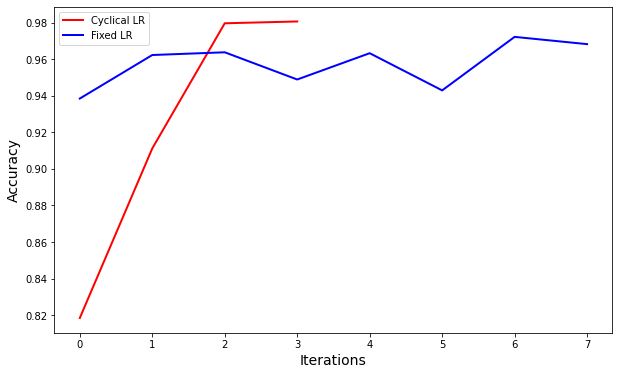

In [28]:
plt.figure(figsize=(10, 6))

plt.plot(acc, 'r-', label='Cyclical LR', linewidth=2)
plt.plot(acc1, 'b-', label='Fixed LR', linewidth=2)

plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend()
plt.savefig("result.jpg")

## Fast ai

In [ ]:
!pip install fastai --upgrade

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.MNIST)
path.ls()[1]

Path('/root/.fastai/data/mnist_png/training')

In [ ]:
def splitter(x): return str(x.parent.parent.name) == 'testing'

db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label
)

In [ ]:
ds = db.datasets(path.ls()[0])

In [ ]:
ds.train, ds.valid

In [ ]:
dls = db.dataloaders(path.ls()[0], bs=32)

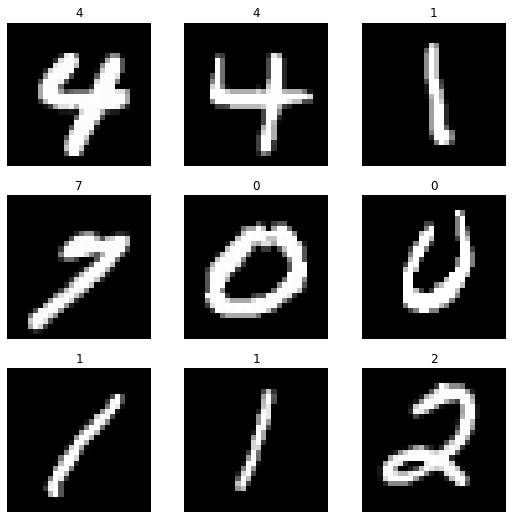

In [ ]:
dls.show_batch()

In [ ]:
db.summary(path)

In [ ]:
learn = Learner(dls, resnet18(pretrained=False), loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.0010000000474974513)

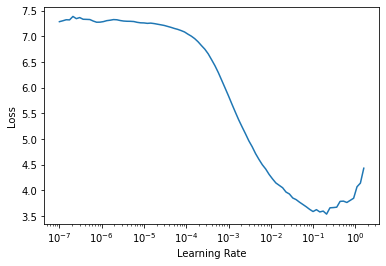

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(8, base_lr=3e-3, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.350900,0.586152,0.840500,00:33
1,0.188595,0.284602,0.913000,00:33
2,0.213820,0.122601,0.962500,00:33
3,0.102351,0.079087,0.977000,00:33
4,0.072047,0.083941,0.976500,00:33
5,0.026256,0.040823,0.985500,00:33
6,0.013390,0.030870,0.989000,00:33
7,0.004982,0.028754,0.990000,00:33
